In [1]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Convex, ECOS
using Distributions, Random  
using LightGraphs  
using Plots

using SparseArrays
using Base.Iterators: product

using Revise
using CarbonNetworks

ECOS_QUIET = () -> ECOS.Optimizer(verbose=false)

┌ Info: Precompiling CarbonNetworks [d5dced0a-5569-40db-8865-1dbf132a76f2]
└ @ Base loading.jl:1317


#1 (generic function with 1 method)

# Load data

### Load network

In [21]:
DATAPATH = "/Users/degleris/Data/carbon_networks/"
A, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH; num_generators=3)
n = length(gmax)
m = length(pmax)

# Remove infinite capacities
pmax[pmax .== Inf] .= 3*maximum(gmax)

normalization = mean(gmax)
gmax /= normalization
pmax /= normalization

@show n, m;

agg_nodes, B = create_generation_map(nodes)

(n, m) = (988, 1079)


(Any[(1, "CISO", "COL"), (2, "AEC", "COL"), (3, "AECI", "COL"), (4, "AZPS", "COL"), (5, "CPLE", "COL"), (6, "CPLW", "COL"), (7, "DUK", "COL"), (8, "EEI", "COL"), (9, "ERCO", "COL"), (10, "FMPP", "COL")  …  (295, "GCPD", "OIL"), (296, "HQT", "OIL"), (297, "MHEB", "OIL"), (298, "SCL", "OIL"), (299, "SEPA", "OIL"), (300, "TPWR", "OIL"), (301, "WAUW", "OIL"), (302, "YAD", "OIL"), (303, "GWA", "OIL"), (304, "WWA", "OIL")], 
⠉⠉⠉⠑⠒⠒⠒⠒⠒⠒⠢⠤⠤⠤⠤⠤⠤⣄⣀⣀⣀⣀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠤⠤⠤⠤⠤⢄⣀⣀⣀⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠉⠉⠉⠉⠑⠒⠒⠒⠒⠒⠒⠤⠄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠉⠉⠉⠒⠒⠒⠒⠒⠒⠒⠤⠤⠤⠤⠤⠤⠤⣀⣀⣀⣀⣀⣀⣀
⠈⠉⠉⠉⠉⠉⠉⠒⠒⠒⠒⠒⠒⠒⠤⠤⠤⠤⠤⠤⠤⣀⣀⣀⣀⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠐⠒⠤⠤⠤⠤⠤⠤⢤⣀⣀⣀⣀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠉⠉⠑⠒⠒⠒⠒⠒
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠉⠉⠉⠉⠉⠒⠒⠒⠒⠒⠒⠢⠤⠤⠤⠤⠤⠤⢄⣀⣀⣀)

In [26]:
size(A)

(988, 1079)

### Load cases

In [15]:
file_names = joinpath.(joinpath(DATAPATH, "TRAIN"), readdir(joinpath(DATAPATH, "TRAIN")))

cases = []
for file in file_names   
    d, g, case = load_case(file, agg_nodes, B, nodes)
    d = d/normalization
    g = g/normalization
    push!(cases, (d=d, g=g, case=case))
end

train_cases = cases[1:500]
test_cases = cases[501:end];

In [ ]:
Random.seed!(4)

# Algorithm parameters
step_size = 1.0
max_iter = 100
batch_size = 2
test_batch_size = 2
λ = 0.0

# Initialize estimated costs
f̂ = rand(Exponential(5), n) .+ 2

train_loss_hist = []
test_loss_hist = []
grad_hist = []

@time for iter in 1:max_iter
    print(".")
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, df = stochastic_loss_and_grad(f̂, B, train_cases, pmax, gmax, A, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, df)
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _ = stochastic_loss_and_grad(f̂, B, test_cases, pmax, gmax, A, sample)
    
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    η = step_size
    Δ = df + λ*f
    f̂ = max.(f̂ - η*(Δ/norm(Δ)), 0)
end
println("Completed $(max_iter) iterations.")

............................................................

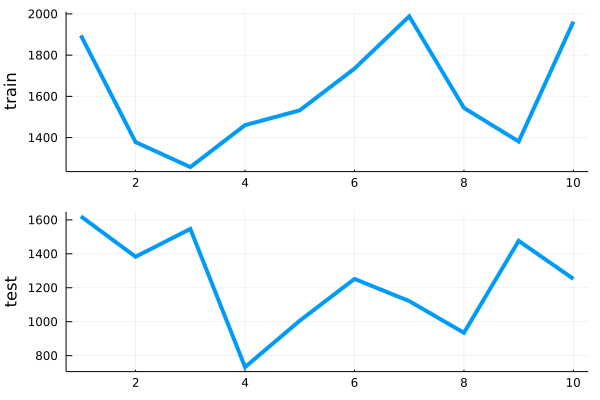

In [32]:
theme(:default, lw=4, label=nothing)

plot(
    plot(train_loss_hist, ylabel="train"),
    plot(test_loss_hist, ylabel="test"),
    layout=(2, 1)
)